In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read csv file
df = pd.read_csv("X:/research paper-implementation/PJMW_hourly_preprocessed_Cnn.csv",parse_dates=['Datetime'], index_col='Datetime')

In [4]:
df

,PJMW_MW,hour,day_of_week,month
Datetime,,,,
2002-04-01 01:00:00,4374.0,1,0,4
2002-04-01 02:00:00,4306.0,2,0,4
2002-04-01 03:00:00,4322.0,3,0,4
2002-04-01 04:00:00,4359.0,4,0,4
2002-04-01 05:00:00,4436.0,5,0,4
...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,3,8
2018-08-02 21:00:00,6496.0,21,3,8
2018-08-02 22:00:00,6325.0,22,3,8


### Data Preparation

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Feature engineering
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# Create lag features
for lag in [1, 24, 168]:  # 1h, 24h, 1-week lags
    df[f'lag_{lag}'] = df['PJMW_MW'].shift(lag)

# Drop missing values
df = df.dropna()

# Select features and scale
features = ['PJMW_MW', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
            'day_of_week', 'lag_1', 'lag_24', 'lag_168']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [6]:
scaled_data

array([[0.45536401, 0.62940952, 0.98296291, ..., 0.47337213, 0.49577248,
        0.42681454],
       [0.44416383, 0.75      , 0.9330127 , ..., 0.45536401, 0.47996047,
        0.41934775],
       [0.43856374, 0.85355339, 0.85355339, ..., 0.44416383, 0.48067421,
        0.42110464],
       ...,
       [0.64104535, 0.25      , 0.9330127 , ..., 0.65982211, 0.64510816,
        0.70363457],
       [0.59349951, 0.37059048, 0.98296291, ..., 0.64104535, 0.59229164,
        0.63335895],
       [0.54924783, 0.5       , 1.        , ..., 0.59349951, 0.53541232,
        0.58449544]])

### Create Time-Series Sequences

In [7]:
n_past = 24  # Use 24 hours of history
n_future = 1  # Predict next hour

X, y = [], []
for i in range(n_past, len(scaled_data) - n_future + 1):
    X.append(scaled_data[i-n_past:i])
    y.append(scaled_data[i+n_future-1, 0])  # PJMW_MW is first column

X, y = np.array(X), np.array(y)

# Reshape for CNN (samples, timesteps, features, 1)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [8]:
# split the data to fix the overlap issue
from sklearn.model_selection import train_test_split
# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Split train into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First Conv Block - Temporal pattern extraction
    Conv2D(32, (3, 3), activation='relu', padding='same', 
           input_shape=(n_past, len(features), 1)),
    MaxPooling2D((2, 1)),  # Reduces timesteps from 24→12, keeps 9 features
    
    # Second Conv Block - Feature pattern extraction
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),  # Reduces timesteps from 12→6
    
    # Third Conv Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),  # Reduces timesteps from 6→3
    
    # Feature dimension reduction
    Conv2D(256, (1, 3), activation='relu'),  # Special 1x3 kernel for features
    
    # Output
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

x:\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 9, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 9, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 7, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       344,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,425 (2.04 MB)

 Trainable params: 535,425 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    shuffle=False
)

Epoch 1/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 0.0092 - mae: 0.0704 - val_loss: 0.0030 - val_mae: 0.0425
Epoch 2/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0025 - mae: 0.0387 - val_loss: 7.1194e-04 - val_mae: 0.0211
Epoch 3/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0010 - mae: 0.0244 - val_loss: 5.1336e-04 - val_mae: 0.0181
Epoch 4/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 7.5277e-04 - mae: 0.0205 - val_loss: 4.4281e-04 - val_mae: 0.0168
Epoch 5/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 6.2210e-04 - mae: 0.0183 - val_loss: 3.4226e-04 - val_mae: 0.0146
Epoch 6/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 4.7177e-04 - mae: 0.0161 - val_loss: 2.9109e-04 - val_mae: 0.0135
Epoch 7/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 4.2149e-04 - mae: 0.0151 - val_loss: 2.4630e-04 - val_mae: 0.0122
Epoch 8/50
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 3.7246e-04 - mae: 0.0142 - val_loss: 2.620

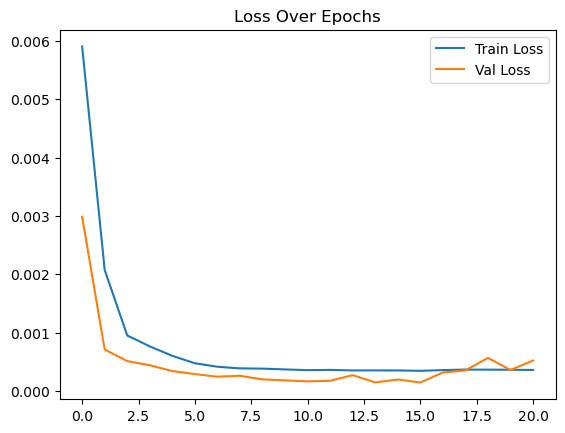

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics in one pass (memory efficient for large datasets)
def batch_predict_evaluate(model, X_test, y_test, batch_size=1000):
    y_pred = model.predict(X_test, batch_size=batch_size).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Safe MAPE calculation
    epsilon = 1e-10  # Prevents division by zero
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    
    return mae, rmse, mape, r2

# Get metrics
test_mae, test_rmse, test_mape, test_r2 = batch_predict_evaluate(model, X_test, y_test)

# Print scaled metrics
print(f"Test MAE (scaled): {test_mae:.4f}")
print(f"Test RMSE (scaled): {test_rmse:.4f}")
print(f"Test R² (scaled): {test_r2:.4f}")

# Convert to original scale
mw_range = df['PJMW_MW'].max() - df['PJMW_MW'].min()
print(f"Test MAE: {test_mae * mw_range:.2f} MW (scaled: {test_mae:.4f})")
print(f"Test RMSE: {test_rmse * mw_range:.2f} MW (scaled: {test_rmse:.4f})")
print(f"Test MAPE: {test_mape:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Test MAE (scaled): 0.0097
Test RMSE (scaled): 0.0121
Test R² (scaled): 0.9877
Test MAE: 88.10 MW (scaled: 0.0097)
Test RMSE: 110.52 MW (scaled: 0.0121)
Test MAPE: 1.77%


895/895 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


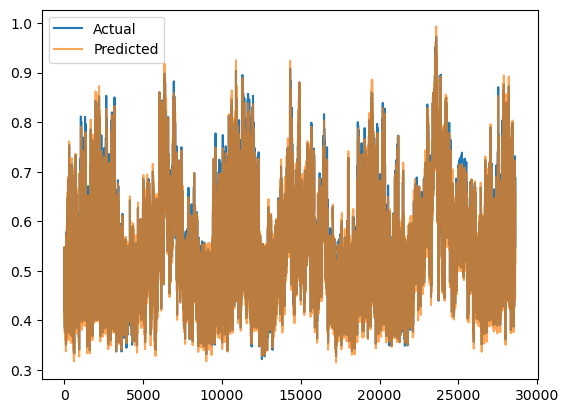

In [13]:
predictions = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

In [13]:
if X_train[-1, -1, 0] < X_val[0, -1, 0]:
    print("✅ No overlap (good)")
else:
    print("❌ Overlap (bad)")

✅ No overlap (good)
